# A case study: the biogeography of *Actinobacteria* under climate changes on the Qinghai-Tibet Plateau

A ***16S rRNA*** gene amplicon sequencing dataset from the Qinghai-Tibet Plateau (QTP) soils is employed to demonstrate the primary functions of microgeo R package. Here, we only focus on the biogeography of ***Actinobacteria*** bacteria under the climate change scenarios, while the more details about the functions of microgeo R package are avaliable in other JupyterLab Notebook (file name: 01.xxx to 10.xxx).

We employ both the regression and classification models of Random Forest to analyze the biogeography of ***Actinobacteria*** bacteria under climate changes on the QTP. The regression model predicts the relative abundance of ***Actinobacteria*** bacteria both at the whole QTP scale and under future climate changes. The classification model predicts the probability of soils dominated by ***Actinobacteria*** bacteria.

***We did not provide the data for our case study (`qtp-16S-stats-dataset-2022-04-01.Rds`) because it is a very large file. Thus, the code provided in this section of the [microgeo](https://github.com/ChaonanLi/microgeo) R package tutorial cannot be executed directly.***

Firstly, we need to load four required R packages into R environment, and we also need to define a function (`savePDF()`) to save the figures into PDF files. All results of this case study would be saved into `../test/case-study`. Just run the following codes.

In [1]:
# Load required R packages 
suppressMessages(require("magrittr")) 
require("ggplot2")  %>% suppressMessages()
require("microgeo") %>% suppressMessages()

# A function for saving figure into PDF file
savePDF = function(object, path, filename, width = 16.4, height = 8.02){
    pdf(file.path(path, filename), width = width, height = height)
        object %>% print() %>% suppressWarnings() %>% suppressMessages()
    dev.off()
}

# Output directory for this case study
outpath <- "test/case_study"
if (!dir.exists(outpath)) dir.create(path = outpath, recursive = T)

## 1. Create a standard microgeo dataset 

Our case study includes 1320 samples (*16S rRNA* gene amplicon sequencing dataset) in total before the rarefying. We use the `read_aliyun_map()` to read a map from the DataV.GeoAtlas (Aliyun, China), and use the `create_dataset()` to create a standard microgeo dataset. 

In [2]:
dataset <- readRDS("../dev/dat/rawdata/qtp-bac-rawdata/qtp-16S-stats-dataset-2022-04-01.Rds")
map <- read_aliyun_map(adcode = c(540000, 630000, 510000)) %>% suppressMessages()
dataset.dts.aliyun <- create_dataset(mat = dataset$unresampled$asv, ant = dataset$unresampled$tax, 
                                     met = dataset$unresampled$met, map = map, lon = "longitude", lat = "latitude") 

ℹ [2024-01-09 22:09:15] INFO ==> all samples fall within the map area!

ℹ [2024-01-09 22:09:15] INFO ==> dataset has been created successfully!

ℹ [2024-01-09 22:09:15] INFO ==> use `object %>% show_dataset()` to check the summary of dataset.



Once the microgeo dataset is successfully created, we can use the `show_dataset()` to check the summary of dataset content. 

In [3]:
dataset.dts.aliyun %>% show_dataset()

── The Summary of Microgeo Dataset ─────────────────────────────────────────────


! object$mat: 83054 ASVs/genes and 1320 samples [need to be subsampled!]

ℹ object$ant: 314746 ASVs/genes and 7 annotation levels (Kingdom, Phylum, Class, Order, Family, Genus, Species)

ℹ object$met: 1443 samples and 3 variables (sample, longitude, latitude)

ℹ object$map: a SpatialPolygonsDataFrame with the CRS of '+proj=longlat +datum=WGS84 +no_defs'




• To check the summary of dataset, Replace `object` with the variable name of your dataset
• For example, if the variable name is `dataset.dts`you can run `head(dataset.dts$met)` to check the content of `met`


Then, we download several spatial data from public repositories using `get_elev()`(elevation), `get_his_bioc()`(historical climate data), `get_fut_bioc()`(future climate data) and `get_modis_cla_metrics()`(land cover). 

In [4]:
dataset.dts.aliyun %<>% get_elev(res = 2.5, out.dir = "test") 
dataset.dts.aliyun %<>% get_his_bioc(res = 2.5, out.dir = "test")
dataset.dts.aliyun %<>% get_fut_bioc(res = 2.5, out.dir = "test", yea = c("2021-2040", "2081-2100"))
dataset.dts.aliyun %<>% get_modis_cla_metrics(username = "username", password = "password", measures = "LC_Type1", out.dir = "test") 

✔ [2024-01-09 22:09:17] SAVE ==> results have been saved to: object$spa$rast$his$ELEV

✔ [2024-01-09 22:09:23] SAVE ==> results have been saved to: object$spa$rast$his(19 variables)

✔ [2024-01-09 22:09:28] SAVE ==> results have been saved to: object$spa$rast$fut [19 variables; 4 groups]

ℹ [2024-01-09 22:09:28] INFO ==> preparing MODIS product list for searching...

ℹ [2024-01-09 22:09:28] INFO ==> searching avaliable MODIS products...

ℹ [2024-01-09 22:09:28] INFO ==> current product (1/1): MCD12Q1 (LC_Type1--> 2022-01-01 to 2022-12-31)

ℹ [2024-01-09 22:09:30] INFO ==> find 8 files with 0.09 GB in total...

ℹ [2024-01-09 22:09:30] INFO ==> downloading all avaliable MODIS products[skip if the file exists]...

ℹ [2024-01-09 22:09:30] INFO ==> preparing the PTVs (Product, Time, Version) for merging remote-sensing images...

ℹ [2024-01-09 22:09:30] INFO ==> converting hdf files to tif files...

ℹ [2024-01-09 22:09:30] INFO ==> current product (1/1): MCD12Q1 (convert 8 hdf files into 1 t

Now we have 20 historically numeric variables, 1 historically classification variable and 4 groups of future climate data. These spatial data would be used for the subsequent ML modeling 

In [5]:
dataset.dts.aliyun %>% show_dataset()

── The Summary of Microgeo Dataset ─────────────────────────────────────────────


! object$mat: 83054 ASVs/genes and 1320 samples [need to be subsampled!]

ℹ object$ant: 314746 ASVs/genes and 7 annotation levels (Kingdom, Phylum, Class, Order, Family, Genus, Species)

ℹ object$met: 1443 samples and 3 variables (sample, longitude, latitude)

ℹ object$map: a SpatialPolygonsDataFrame with the CRS of '+proj=longlat +datum=WGS84 +no_defs'




── The Summary of Biogeographic Traits ─────────────────────────────────────────


✔ object$spa: 20 historically numeric variables; 1 historically classification variables; 4 groups of future climate data




• To check the summary of dataset, Replace `object` with the variable name of your dataset
• For example, if the variable name is `dataset.dts`you can run `head(dataset.dts$met)` to check the content of `met`


Now, we need to extract spatial data for each soil sample. The warning could be ignore because this dataset would be further processed.

In [6]:
dataset.dts.aliyun %<>% extract_data_from_spatraster()
head(dataset.dts.aliyun$spa$tabs)

! [2024-01-09 22:10:04] WARN ==> Some samples were failed to be applied for extraction. use `remove.na = FALSE` to check them!

✔ [2024-01-09 22:10:04] SAVE ==> results have been saved to: object$spa$tabs



LC_Type1 ELEV Bio1     Bio2     Bio3     Bio4     Bio5   Bio6   
Q4-G20-1  16       4456 2.951500 15.60033 49.16278 611.4689 17.708 -14.024
Q5-G20-2  16       4456 2.951500 15.60033 49.16278 611.4689 17.708 -14.024
Q6-G20-3  16       4456 2.951500 15.60033 49.16278 611.4689 17.708 -14.024
Q10-G22-1 16       4181 4.222833 15.24567 48.46664 629.6671 18.600 -12.856
Q11-G22-2 16       4181 4.222833 15.24567 48.46664 629.6671 18.600 -12.856
Q12-G22-3 16       4181 4.222833 15.24567 48.46664 629.6671 18.600 -12.856
          Bio7   Bio8     ⋯ Bio10    Bio11  Bio12 Bio13 Bio14 Bio15    Bio16
Q4-G20-1  31.732  7.20400 ⋯ 10.23933 -4.728 454    54   12    34.91031 152  
Q5-G20-2  31.732  7.20400 ⋯ 10.23933 -4.728 454    54   12    34.91031 152  
Q6-G20-3  31.732  7.20400 ⋯ 10.23933 -4.728 454    54   12    34.91031 152  
Q10-G22-1 31.456 11.10733 ⋯ 11.73867 -3.696 520   106    7    75.01073 275  
Q11-G22-2 31.456 11.10733 ⋯ 11.73867 -3.696 520   106    7    75.01073 275  
Q12-G22-3 31.456 11.10733 ⋯ 11.73867 -3.696 520   106    7    75.01073 275  
          Bio17 Bio18 Bio19
Q4-G20-1  68    131   105  
Q5-G20-2  68    131   105  
Q6-G20-3  68    131   105  
Q10-G22-1 33    264    48  
Q11-G22-2 33    264    48  
Q12-G22-3 33    264    48

Because of the differences of sequencing depth, we also need to rarefy the count table. Please note that this function should be run before the `tidy_dataset()` because the rarefying would discard several samples/ASVs/genes, while the `tidy_dataset()` would sort the order of both sample and asv/gene ids. Here we rarefy the sequence number to 5000 for each soil sample. The resampling depth of 5000 just for test, a larger value may be better.

In [7]:
dataset.dts.aliyun %<>% rarefy_count_table(depth = 5000)

ℹ [2024-01-09 22:10:28] INFO ==> the ASV/gene abundance table has been rarefied with a sub-sample depth of 5000



Finally, we need to tidy up the microgeo dataset, and the final dataset now can be used for subsequent analysis.

In [8]:
dataset.dts.aliyun %<>% tidy_dataset()
dataset.dts.aliyun %>% show_dataset()

── The Summary of Microgeo Dataset ─────────────────────────────────────────────


ℹ object$mat: 72509 ASVs/genes and 1100 samples [subsample depth: 5000]

ℹ object$ant: 72509 ASVs/genes and 7 annotation levels (Kingdom, Phylum, Class, Order, Family, Genus, Species)

ℹ object$met: 1100 samples and 3 variables (sample, longitude, latitude)

ℹ object$map: a SpatialPolygonsDataFrame with the CRS of '+proj=longlat +datum=WGS84 +no_defs'




── The Summary of Biogeographic Traits ─────────────────────────────────────────


✔ object$spa: 20 historically numeric variables; 1 historically classification variables; 4 groups of future climate data




• To check the summary of dataset, Replace `object` with the variable name of your dataset
• For example, if the variable name is `dataset.dts`you can run `head(dataset.dts$met)` to check the content of `met`


## 2. Plot a sampling map 

Now, we plot a geographic map to display the location of our sampling sites based on the microgeo dataset we created above. Here we use the elevation as a base layer of sampling map.

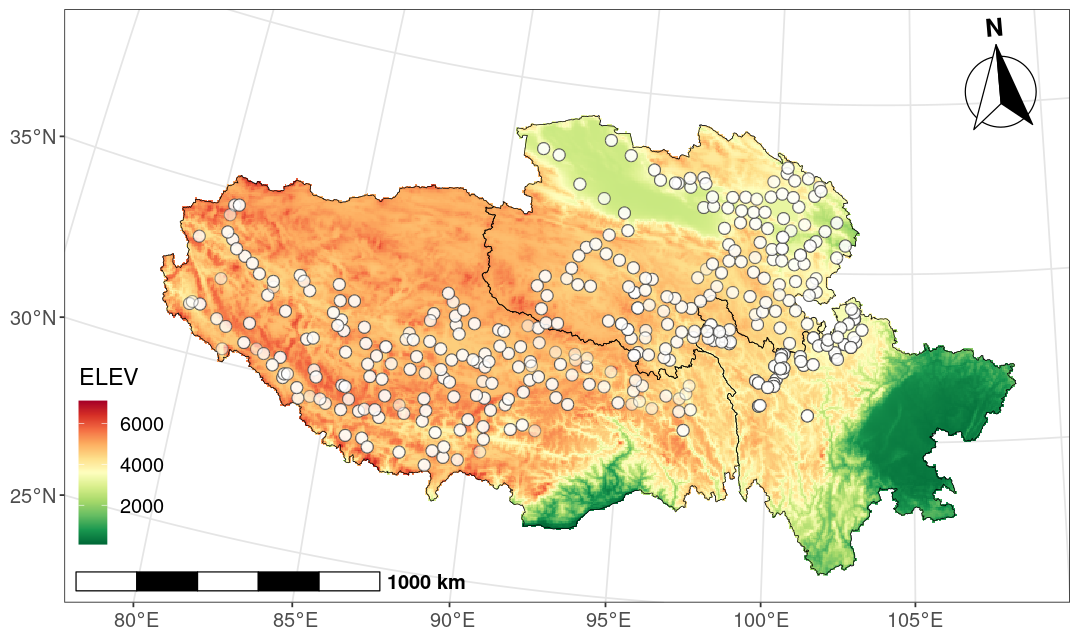

In [9]:
options(repr.plot.width = 13.5/1.5, repr.plot.height = 8.02/1.5)
(p.samp.map <- dataset.dts.aliyun$map %>% 
    plot_bmap(legend.position = c(0.0575, 0.25)) %>% 
    add_spatraster(spat.raster = dataset.dts.aliyun$spa$rast$his$ELEV) %>% 
    add_sampl_site(met = dataset.dts.aliyun$met, color.val = "gray30", fill.val = "white", point.alpha = 0.5) %>% 
    add_scale_bar() %>% add_north_arrow() %>% add_crs())
saved <- savePDF(object = p.samp.map, path = outpath, filename = "sampling-site-map.pdf", width = 13.5/1.5, height = 8.02/1.5)

## 3. Analyze the climates of our study area

Then, we analyze the climates of our study area. We focus on the Bio1 (MAT) and Bio12 (MAP) in this section.

In [10]:
# Combines the historical and future Bio1 to one SpatRaster.
his.bio1 <- dataset.dts.aliyun$spa$rast$his$Bio1
ssp126.2021to2040.bio1 <- dataset.dts.aliyun$spa$rast$fut$`BCC-CSM2-MR|ssp126|2021-2040`$Bio1
ssp126.2081to2100.bio1 <- dataset.dts.aliyun$spa$rast$fut$`BCC-CSM2-MR|ssp126|2081-2100`$Bio1
ssp585.2021to2040.bio1 <- dataset.dts.aliyun$spa$rast$fut$`BCC-CSM2-MR|ssp585|2021-2040`$Bio1
ssp585.2081to2100.bio1 <- dataset.dts.aliyun$spa$rast$fut$`BCC-CSM2-MR|ssp585|2081-2100`$Bio1
all.bio1 <- c(his.bio1              , his.bio1, 
              ssp126.2021to2040.bio1, ssp585.2021to2040.bio1, 
              ssp126.2081to2100.bio1, ssp585.2081to2100.bio1)
names(all.bio1) <- c("Historical"      , "Historical.dup", 
                     "SSP126|2021-2040", "SSP585|2021-2040",
                     "SSP126|2081-2100", "SSP585|2081-2100")

In [11]:
# Combines the historical and future Bio12 to one SpatRaster.
his.bio12 <- dataset.dts.aliyun$spa$rast$his$Bio12
ssp126.2021to2040.bio12 <- dataset.dts.aliyun$spa$rast$fut$`BCC-CSM2-MR|ssp126|2021-2040`$Bio12
ssp126.2081to2100.bio12 <- dataset.dts.aliyun$spa$rast$fut$`BCC-CSM2-MR|ssp126|2081-2100`$Bio12
ssp585.2021to2040.bio12 <- dataset.dts.aliyun$spa$rast$fut$`BCC-CSM2-MR|ssp585|2021-2040`$Bio12
ssp585.2081to2100.bio12 <- dataset.dts.aliyun$spa$rast$fut$`BCC-CSM2-MR|ssp585|2081-2100`$Bio12
all.bio12 <- c(his.bio12              , his.bio12, 
               ssp126.2021to2040.bio12, ssp585.2021to2040.bio12, 
               ssp126.2081to2100.bio12, ssp585.2081to2100.bio12)
names(all.bio12) <- c("Historical"      , "Historical.dup", 
                      "SSP126|2021-2040", "SSP585|2021-2040",
                      "SSP126|2081-2100", "SSP585|2081-2100")

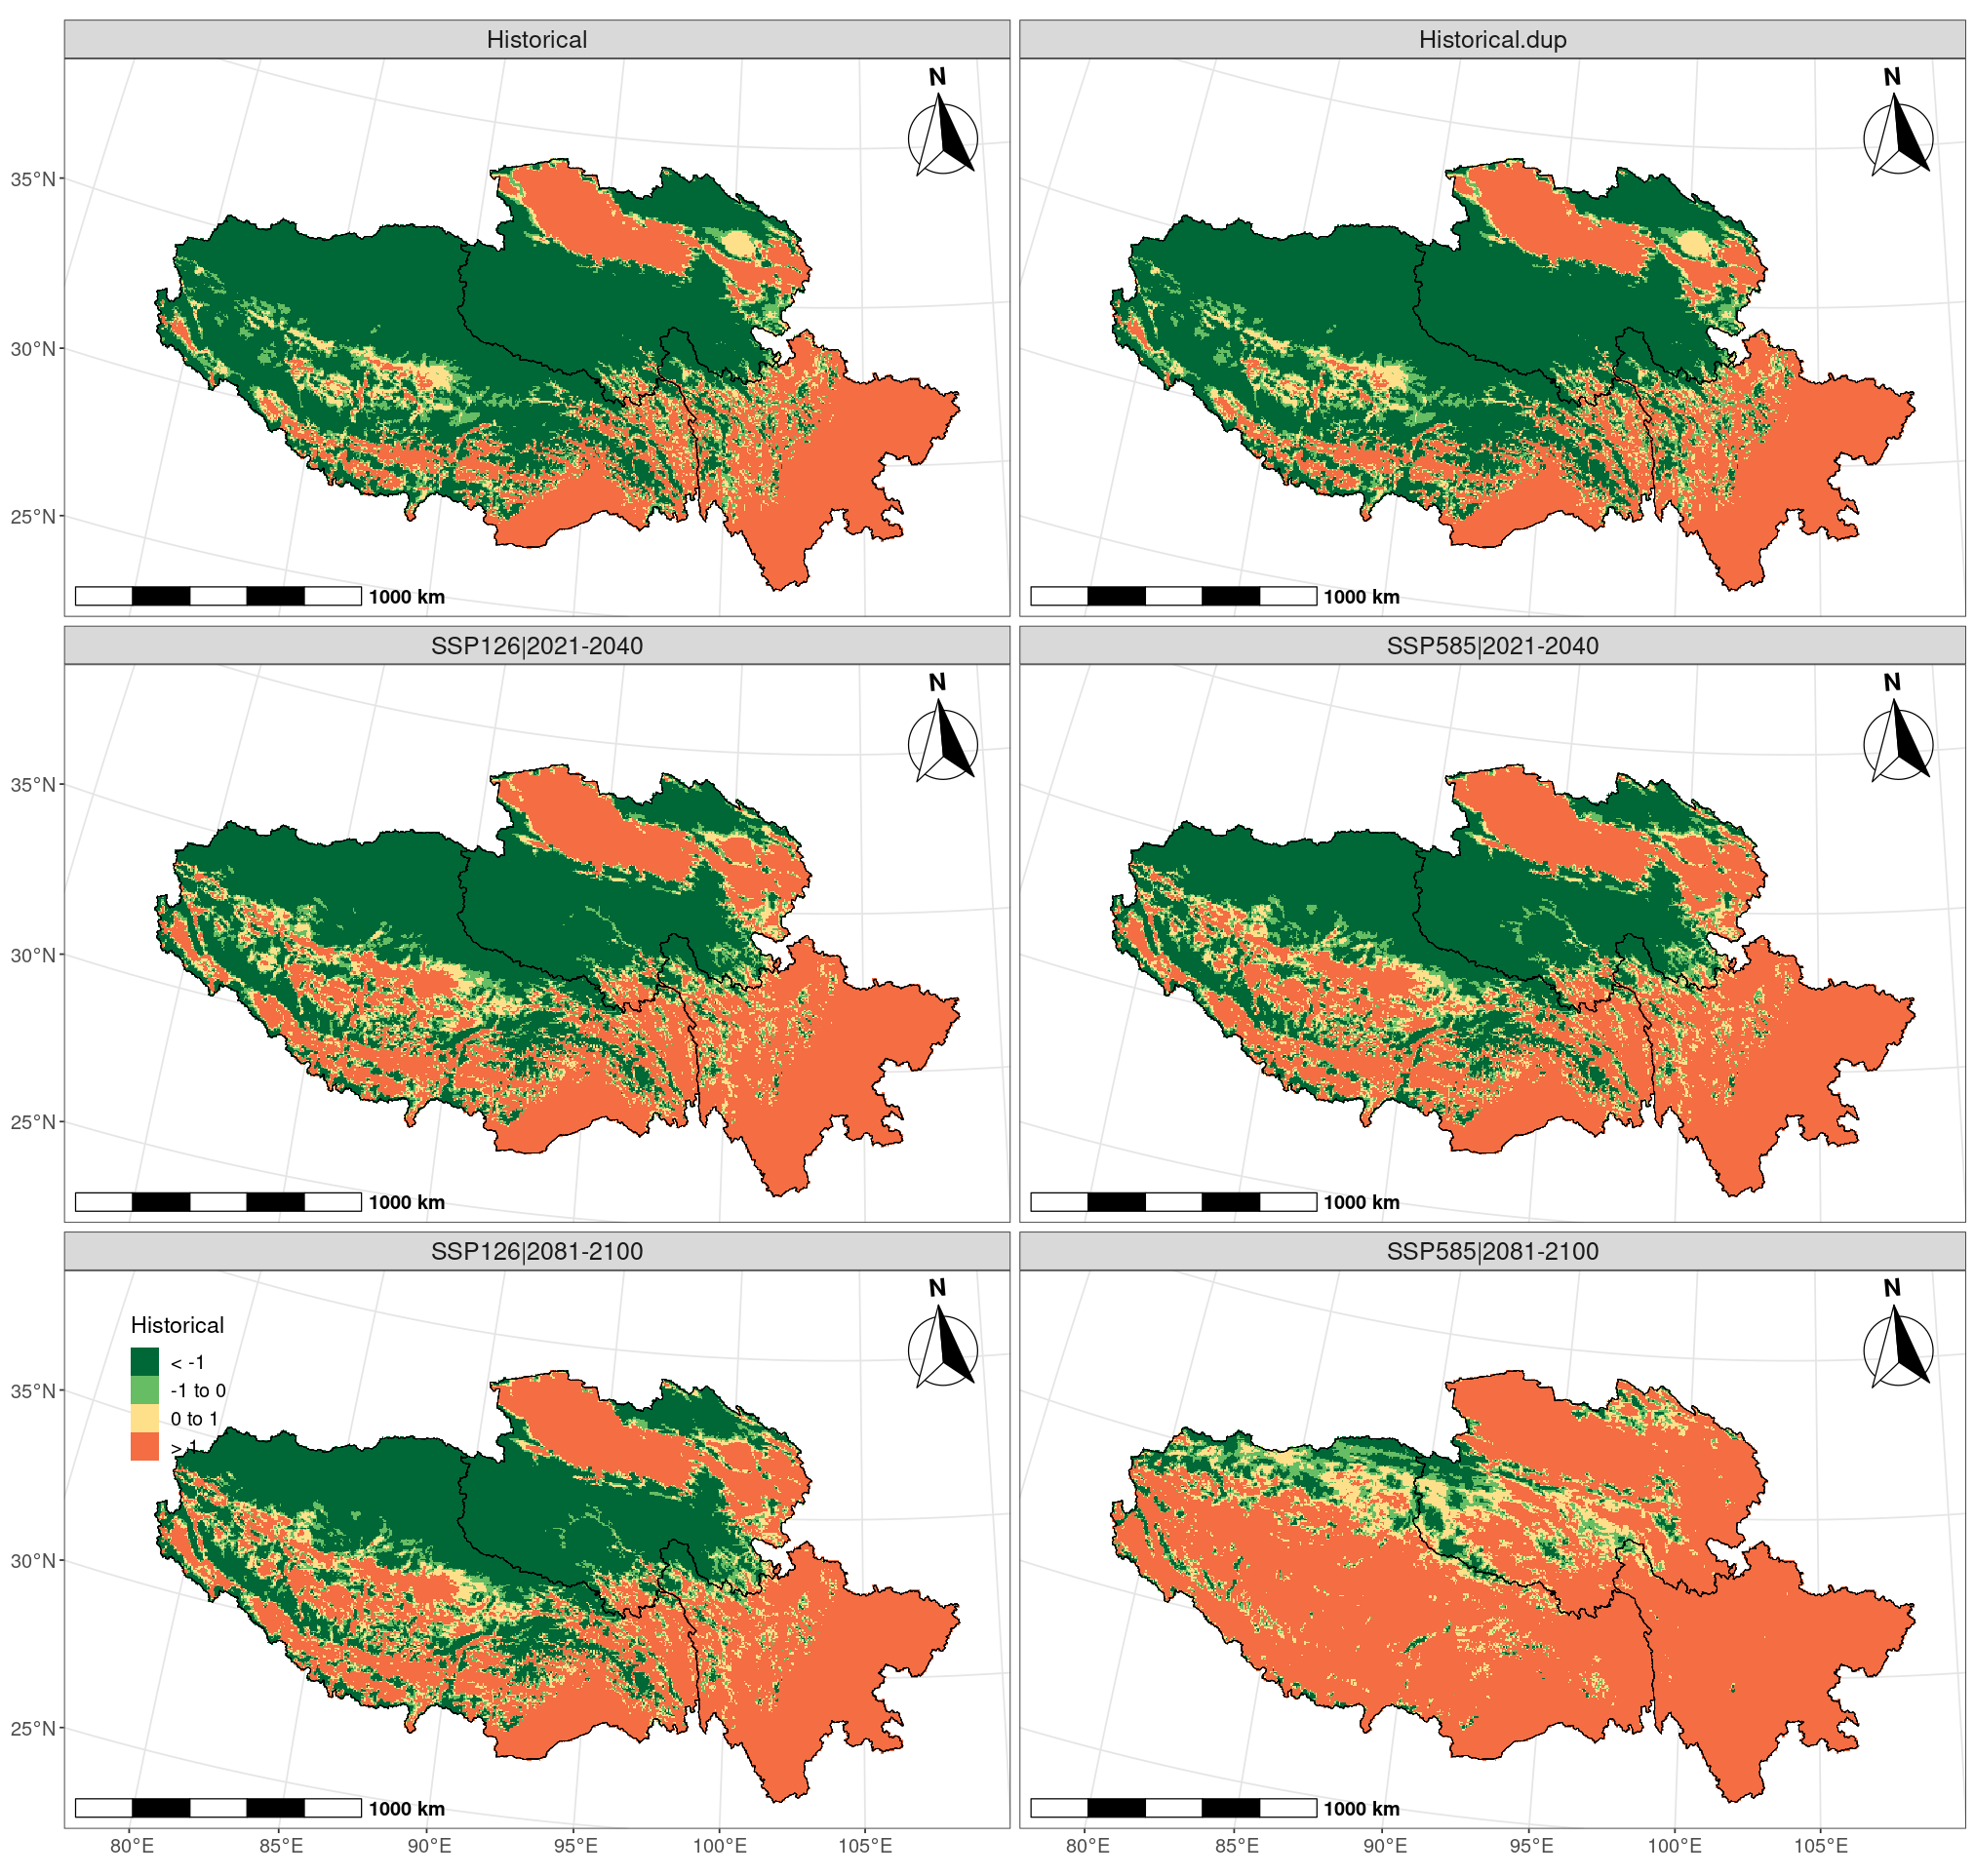

In [12]:
# Visualize the bio1 (MAT). The results indicate that the QTP would be warmer in the future
options(repr.plot.width = (13.5/1.6) * 2, repr.plot.height = (8.02/1.5) * 3)
(p.his.bio1 <- dataset.dts.aliyun$map %>% 
    plot_bmap(legend.position = c(0.06, 0.25)) %>% 
    add_spatraster(spat.raster = all.bio1, facet.col.nums = 2, breaks = c(-1, 0, 1), labels = c("< -1", "-1 to 0", "0 to 1", "> 1")) %>% 
    add_scale_bar() %>% add_north_arrow() %>% add_crs())
saved <- savePDF(object = p.his.bio1, path = outpath, filename = "bio1.pdf", width = (13.5/1.6) * 2, height = (8.02/1.5) * 3)

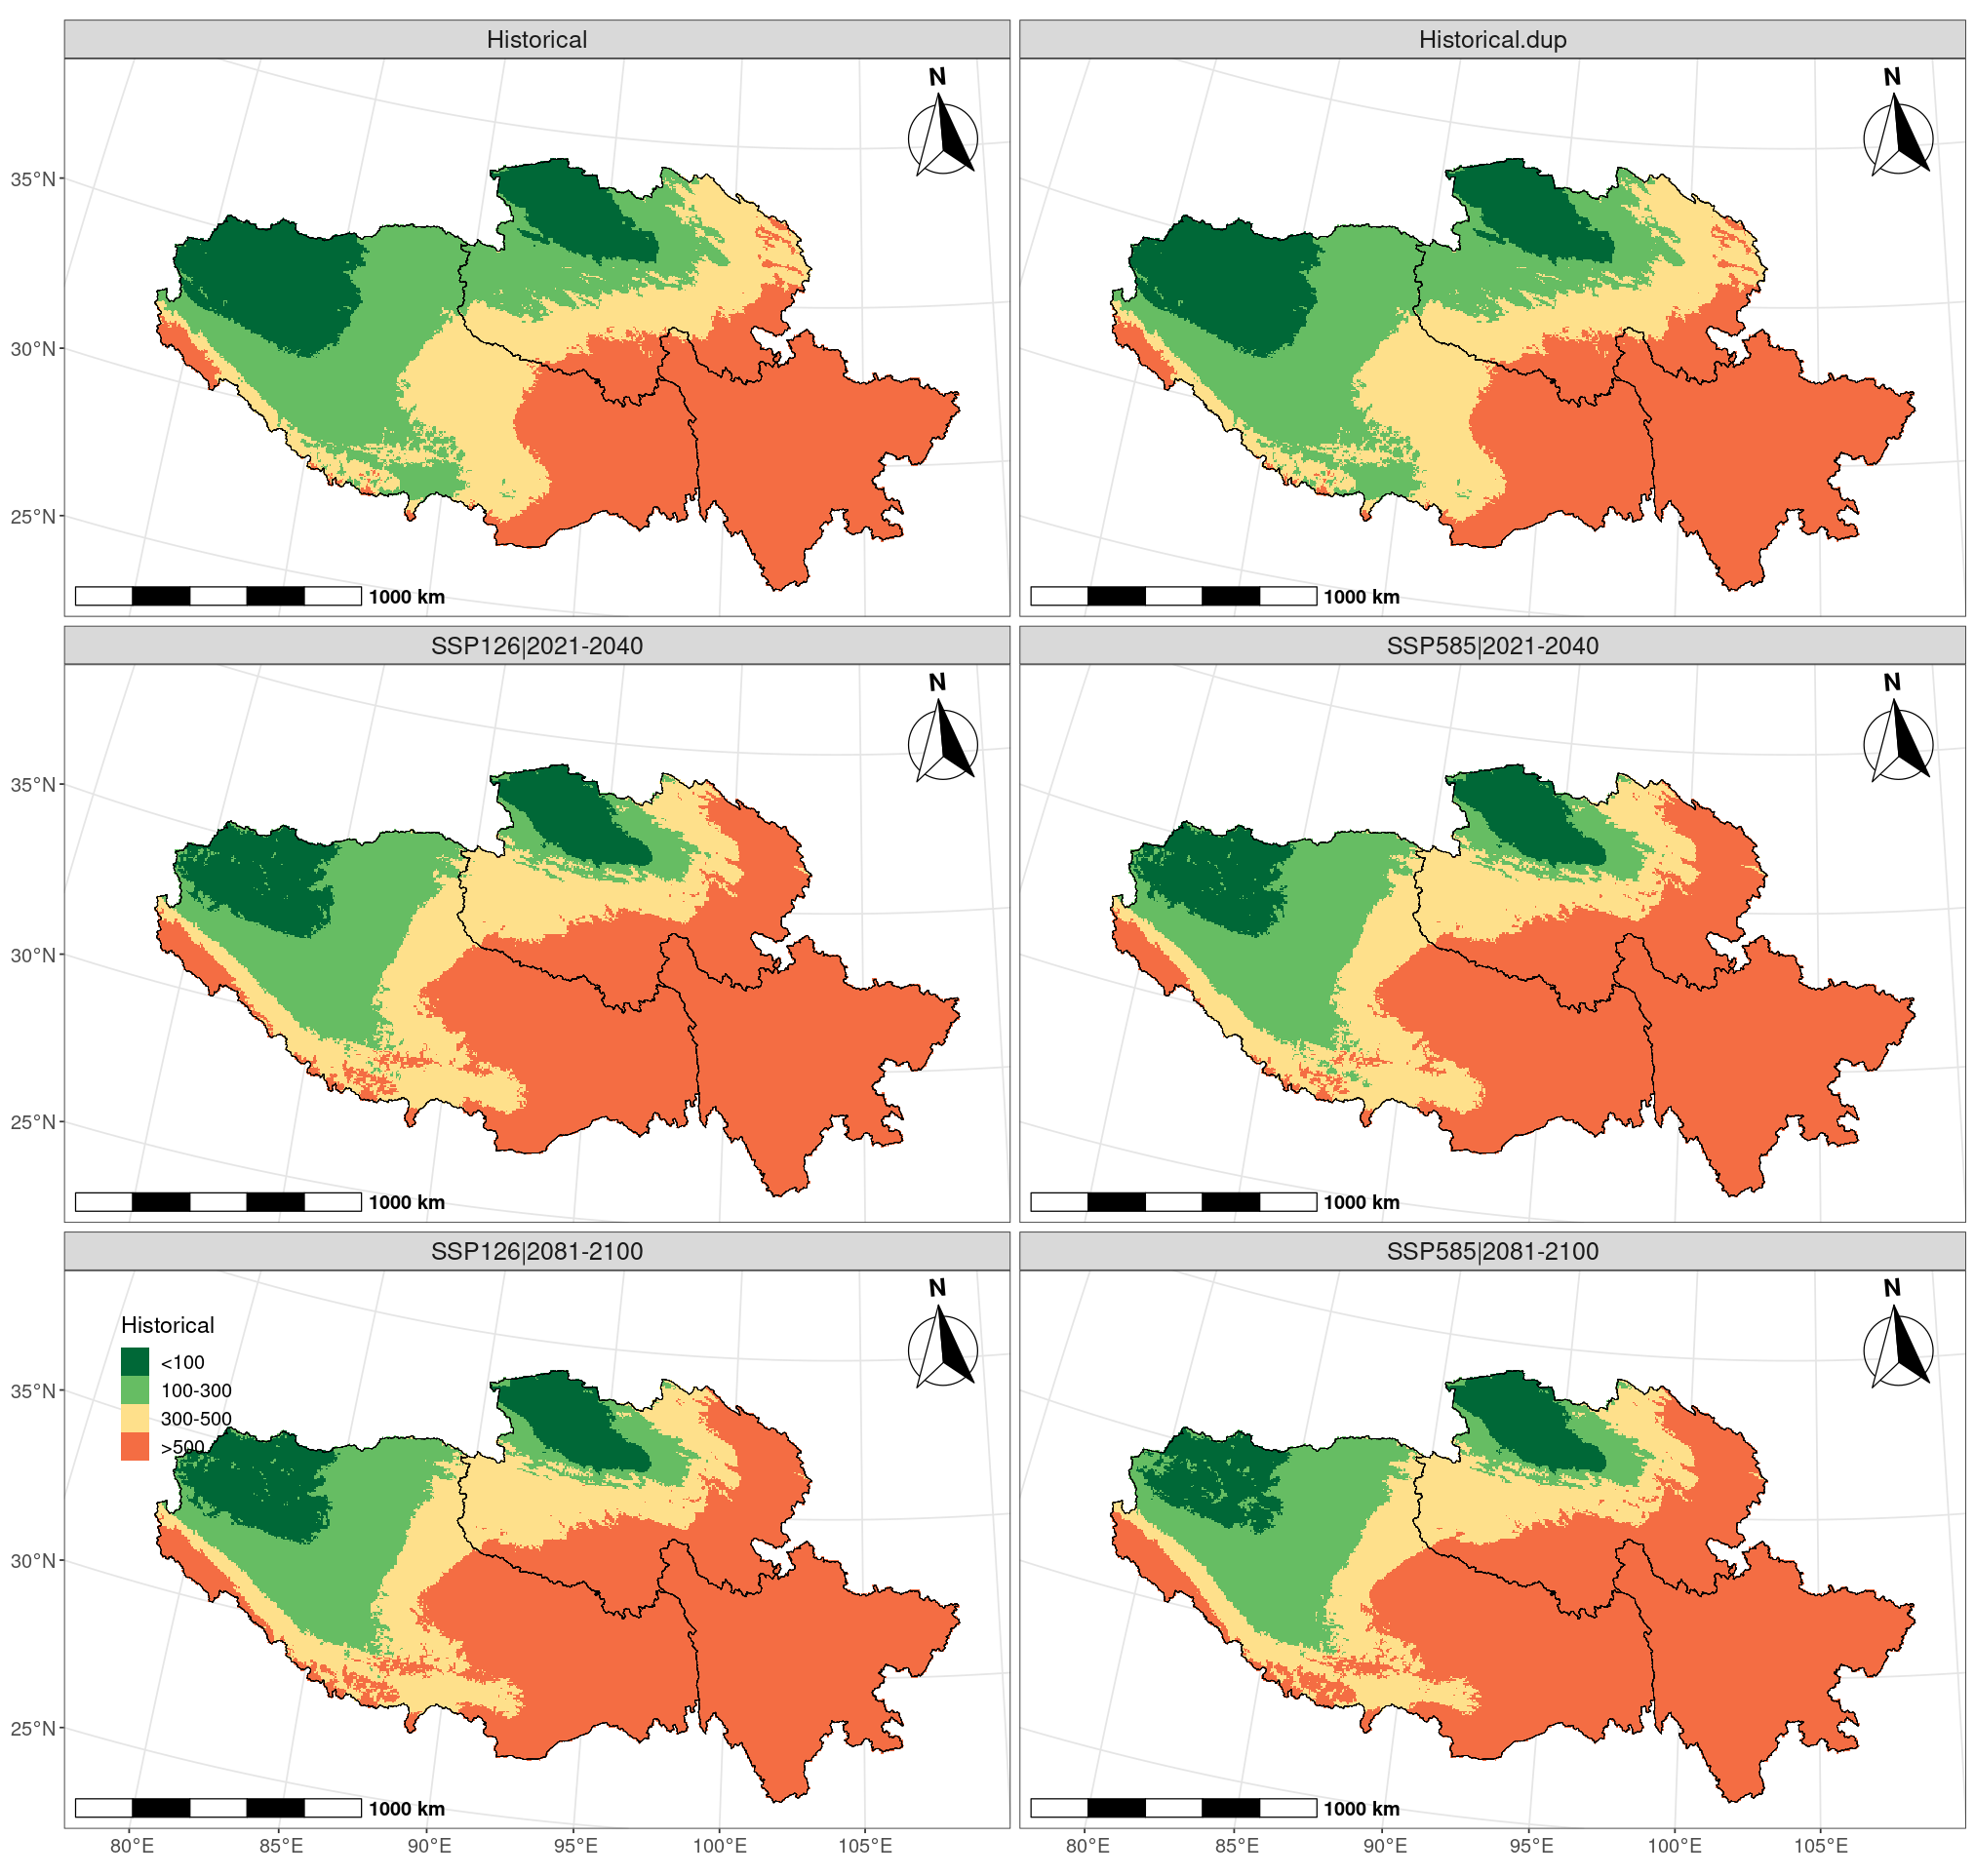

In [13]:
# Visualize the bio12 (MAP). The results indicate that the QTP also would be wetter in the future
options(repr.plot.width = (13.5/1.6) * 2, repr.plot.height = (8.02/1.5) * 3)
(p.his.bio12 <- dataset.dts.aliyun$map %>% 
    plot_bmap(legend.position = c(0.06, 0.25)) %>% 
    add_spatraster(spat.raster = all.bio12, facet.col.nums = 2, breaks = c(100, 300, 500), labels = c("<100", "100-300", "300-500", ">500")) %>% 
    add_scale_bar() %>% add_north_arrow() %>% add_crs())
saved <- savePDF(object = p.his.bio12, path = outpath, filename = "bio12.pdf", width = (13.5/1.6) * 2, height = (8.02/1.5) * 3)

## 4. Calculate the relative abundance

In [14]:
# Calculate the relative abundance
dataset.dts.aliyun %<>% calc_rel_abund() 
dataset.dts.aliyun %>%  show_dataset()

✔ [2024-01-09 22:16:33] SAVE ==> results have been saved to: object$abd$raw



── The Summary of Microgeo Dataset ─────────────────────────────────────────────


ℹ object$mat: 72509 ASVs/genes and 1100 samples [subsample depth: 5000]

ℹ object$ant: 72509 ASVs/genes and 7 annotation levels (Kingdom, Phylum, Class, Order, Family, Genus, Species)

ℹ object$met: 1100 samples and 3 variables (sample, longitude, latitude)

ℹ object$map: a SpatialPolygonsDataFrame with the CRS of '+proj=longlat +datum=WGS84 +no_defs'




── The Summary of Biogeographic Traits ─────────────────────────────────────────


✔ object$spa: 20 historically numeric variables; 1 historically classification variables; 4 groups of future climate data

✔ object$abd$raw: 7 abundance tables (Kingdom, Phylum, Class, Order, Family, Genus, Species)




• To check the summary of dataset, Replace `object` with the variable name of your dataset
• For example, if the variable name is `dataset.dts`you can run `head(dataset.dts$met)` to check the content of `met`


In [15]:
# Check the relative abundance
head(dataset.dts.aliyun$abd$raw$Phylum[,1:10])

p__  p__Acidobacteria p__Actinobacteria p__Armatimonadetes
CXB116 0.70 13.74            45.74             0.20              
CXB117 0.66 12.52            49.26             0.26              
CXB118 0.38 19.92            42.86             0.08              
CXB119 0.36 14.72            45.24             0.16              
CXB120 0.24 12.82            55.38             0.12              
CXB121 0.44 15.34            43.48             0.10              
       p__Bacteroidetes p__BRC1 p__Chloroflexi p__Cloacimonetes
CXB116 2.54             0.02    5.94           0               
CXB117 3.06             0.02    5.42           0               
CXB118 1.52             0.00    8.18           0               
CXB119 5.56             0.00    6.84           0               
CXB120 1.62             0.00    5.86           0               
CXB121 2.62             0.00    7.36           0               
       p__Crenarchaeota p__Cyanobacteria
CXB116 0                0.30            
CXB117 0                1.92            
CXB118 0                0.12            
CXB119 0                2.20            
CXB120 0                0.14            
CXB121 0                0.00

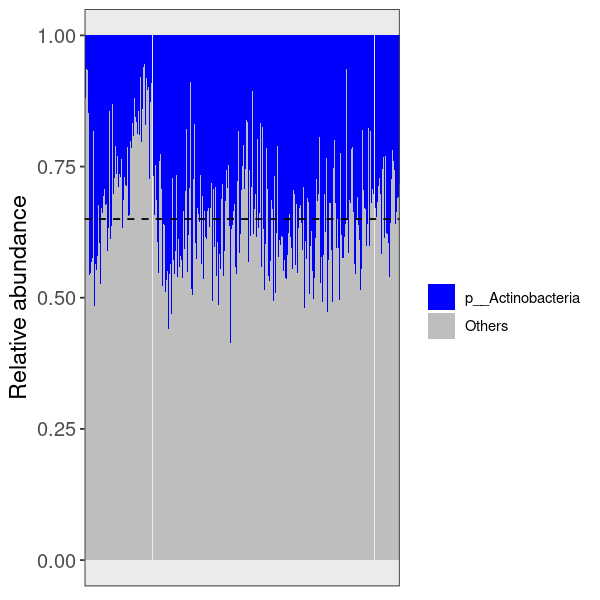

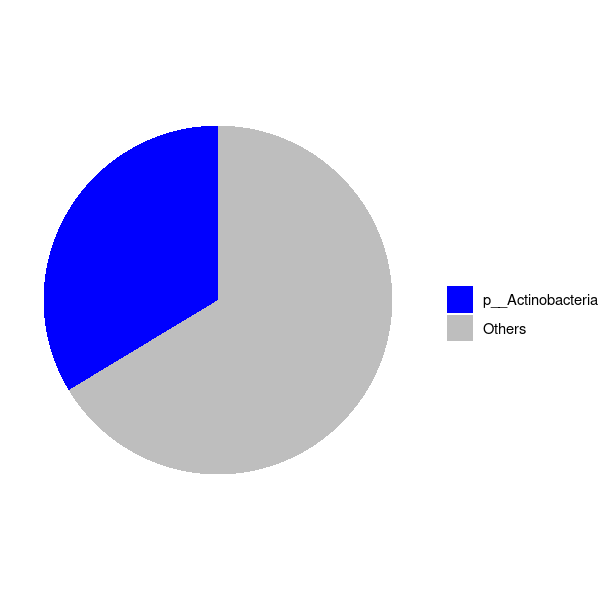

In [16]:
# Plot bar charts for `p__Actinobacteria`
options(repr.plot.width = 5, repr.plot.height = 5)
plotdat <- data.frame(sample = rownames(dataset.dts.aliyun$abd$raw$Phylum),
                     p__Actinobacteria = dataset.dts.aliyun$abd$raw$Phylum$p__Actinobacteria, 
                     Others = 100 - dataset.dts.aliyun$abd$raw$Phylum$p__Actinobacteria) %>% reshape2::melt() %>% suppressMessages() 
(p.bar <- ggplot(plotdat, aes(x = sample, y = value)) + geom_bar(stat = 'identity', position = 'fill', aes(fill = variable), width = 1) + 
    theme_bw() + ylab("Relative abundance") + 
     geom_hline(yintercept = 0.65, linetype = 2) + 
    theme(axis.title.x = element_blank(), axis.text.x = element_blank(), axis.ticks.x = element_blank(),
          axis.title.y = element_text(size = 14), axis.text.y = element_text(size = 12)) + 
    scale_fill_manual(name = "", values = c("blue", "gray")))
(p.pie <- ggplot(plotdat, aes(x = "", y = value, fill = variable)) +
  geom_bar(stat = "identity", width = 1) +
  coord_polar("y", start = 0) +
  theme_void() + scale_fill_manual(name = "", values = c("blue", "gray")))
saved <- savePDF(object = p.bar, path = outpath, filename = "p.bar.pdf", width = 5, height = 5)
saved <- savePDF(object = p.pie, path = outpath, filename = "p.pie.pdf", width = 5, height = 5)

## 5. Create Random Forest models

In [17]:
# A regression model 
reg <- create_ml_model(y.data = dataset.dts.aliyun$abd$raw$Phylum, 
                       x.data = dataset.dts.aliyun$spa$tabs[,paste0("Bio", seq(19))], 
                       var = "p__Actinobacteria", method = 'rf', threads = 60)

In [18]:
# A classification model. Here we only focused on `p__Actinobacteria`
# If the relative abundance is more than 35%, then we define such a sample as p__Actinobacteria predominated soil
phyla.bins <- data.frame(row.names = rownames(dataset.dts.aliyun$abd$raw$Phylum), 
                         p__Actinobacteria = dataset.dts.aliyun$abd$raw$Phylum$p__Actinobacteria)
phyla.bins$p__Actinobacteria <- ifelse(phyla.bins$p__Actinobacteria > 35, "predominated", "non-predominated")
table(phyla.bins$p__Actinobacteria)
phyla.bins$p__Actinobacteria <- as.factor(phyla.bins$p__Actinobacteria)
cla <- create_ml_model(y.data = phyla.bins, 
                       x.data = dataset.dts.aliyun$spa$tabs[,paste0("Bio", seq(19))],
                       var = 'p__Actinobacteria', method = 'rf', type = 'classification')


non-predominated     predominated 
             571              529 

## 6. Evaluate Random Forest models

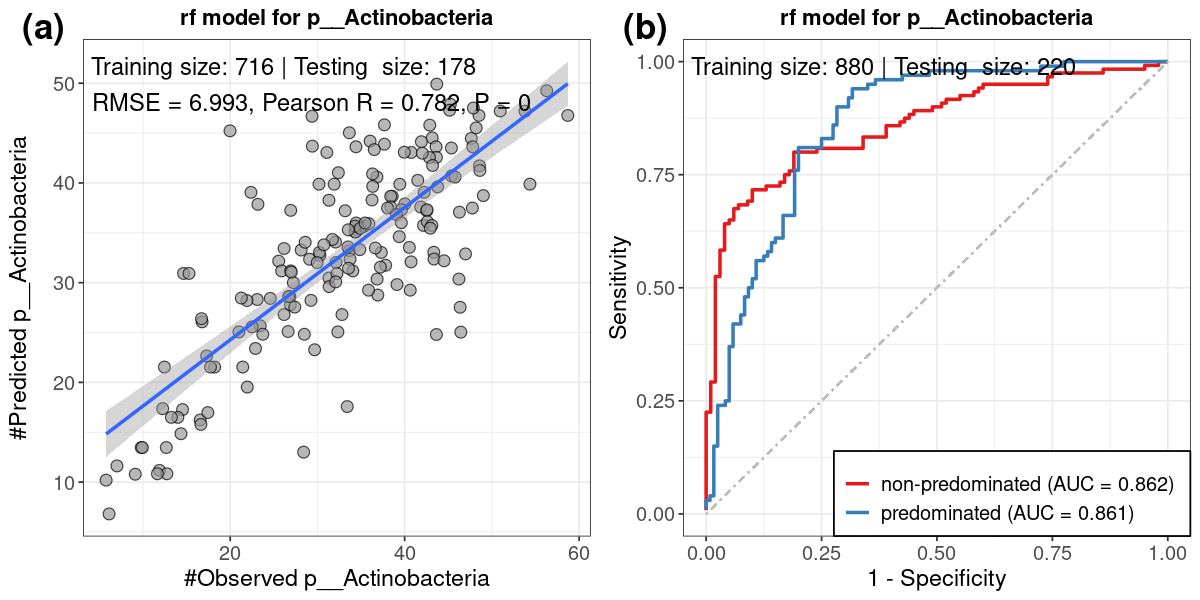

In [19]:
# Model performace
options(repr.plot.width = 10, repr.plot.height = 5)
p.reg.eva <- reg %>% evaluate_ml_model()
p.cla.eva <- cla %>% evaluate_ml_model()
(p.eva <- cowplot::plot_grid(p.reg.eva, p.cla.eva, align = 'hv', ncol = 2, labels = c('(a)', '(b)'), label_size = 21) %>% suppressWarnings())
saved <- savePDF(object = p.eva, path = outpath, filename = "p.eva.pdf", width = 10, height = 5)

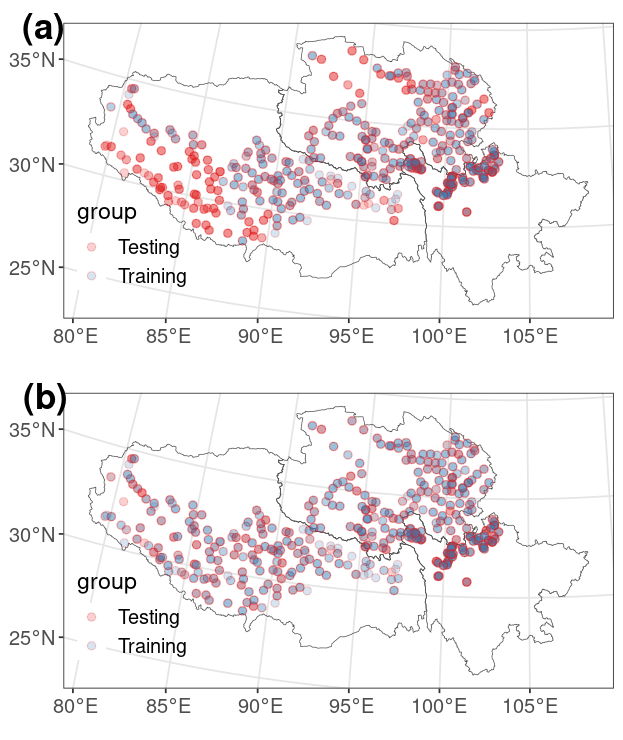

In [20]:
# The map of training and testing data 
options(repr.plot.width = 13.5/1.3/2, repr.plot.height = 8.02/1.3)
new.met.reg <- dataset.dts.aliyun$met
new.met.cla <- dataset.dts.aliyun$met
new.met.reg$group <- ifelse(rownames(new.met.reg) %in% rownames(reg$train.dat), "Training", "Testing")
new.met.cla$group <- ifelse(rownames(new.met.cla) %in% rownames(cla$train.dat), "Training", "Testing")
p.map.reg <- dataset.dts.aliyun$map %>% 
    plot_bmap(legend.position = c(0.125, 0.25)) %>% 
    add_sampl_site(met = new.met.reg, color.var = "group", point.alpha = 0.2, point.size = 2) %>% add_crs()
p.map.cla <- dataset.dts.aliyun$map %>% 
    plot_bmap(legend.position = c(0.125, 0.25)) %>% 
    add_sampl_site(met = new.met.cla, color.var = "group", point.alpha = 0.2, point.size = 2) %>% add_crs()
(p.model.sampl.map <- cowplot::plot_grid(p.map.reg, p.map.cla, align = 'hv', ncol = 1, labels = c('(a)', '(b)'), label_size = 21) %>% suppressWarnings())
saved <- savePDF(object = p.model.sampl.map, path = outpath, filename = "p.model.sampl.map.pdf", width = 13.5/1.3/2, height = 8.02/1.3)

## 7. Predict the biogeography of `p__Actinobacteria`

In [21]:
# Prepare the climate data for predictions 
climate.data <- list(
    dataset.dts.aliyun$spa$rast$his[[paste0("Bio", seq(19))]],
    dataset.dts.aliyun$spa$rast$fut$`BCC-CSM2-MR|ssp126|2021-2040`,
    dataset.dts.aliyun$spa$rast$fut$`BCC-CSM2-MR|ssp126|2081-2100`,
    dataset.dts.aliyun$spa$rast$fut$`BCC-CSM2-MR|ssp585|2021-2040`,
    dataset.dts.aliyun$spa$rast$fut$`BCC-CSM2-MR|ssp585|2081-2100`
)
names(climate.data) <- c("Historical", "SSP126|2021-2040", "SSP126|2081-2100", "SSP585|2021-2040", "SSP585|2081-2100")

In [22]:
# Predictions of relative abundance
bio <- list(10, 16, c(1:5)) # "Grasslands", "Barren", "Forests"
reg.pred.rst <- lapply(climate.data, function(climate) reg %>% predict_ml_geomap(spat.raster = climate))      
reg.pred.rst.masked <- lapply(reg.pred.rst, FUN = function(pre){
    inner.res <- lapply(bio, FUN = function(b){
        mask_spatraster_by_cla(tar.spat = pre, ref.spat = dataset.dts.aliyun$spa$rast$cla$LC_Type1, use.class = b)
    })
    names(inner.res) <- c("Grasslands", "Barren", "Forests")
    inner.res
})  

In [23]:
# Prepare visualizition data: SSP126
reg.visual.dat.ssp126 <- c(
    reg.pred.rst.masked$Historical$Grasslands        , reg.pred.rst.masked$Historical$Barren        , reg.pred.rst.masked$Historical$Forests,
    reg.pred.rst.masked$`SSP126|2021-2040`$Grasslands, reg.pred.rst.masked$`SSP126|2021-2040`$Barren, reg.pred.rst.masked$`SSP126|2021-2040`$Forests,
    reg.pred.rst.masked$`SSP126|2081-2100`$Grasslands, reg.pred.rst.masked$`SSP126|2081-2100`$Barren, reg.pred.rst.masked$`SSP126|2081-2100`$Forests
)
names(reg.visual.dat.ssp126) <- c("Historical|Grasslands", "Historical|Barren", "Historical|Forests", 
                                  "SSP126|2021-2040|Grasslands", "SSP126|2021-2040|Barren", "SSP126|2021-2040|Forests",
                                  "SSP126|2081-2100|Grasslands", "SSP126|2081-2100|Barren", "SSP126|2081-2100|Forests")

In [24]:
# Prepare visualizition data: SSP585
reg.visual.dat.ssp585 <- c(
    reg.pred.rst.masked$Historical$Grasslands        , reg.pred.rst.masked$Historical$Barren        , reg.pred.rst.masked$Historical$Forests,
    reg.pred.rst.masked$`SSP585|2021-2040`$Grasslands, reg.pred.rst.masked$`SSP585|2021-2040`$Barren, reg.pred.rst.masked$`SSP585|2021-2040`$Forests,
    reg.pred.rst.masked$`SSP585|2081-2100`$Grasslands, reg.pred.rst.masked$`SSP585|2081-2100`$Barren, reg.pred.rst.masked$`SSP585|2081-2100`$Forests
)
names(reg.visual.dat.ssp585) <- c("Historical|Grasslands", "Historical|Barren", "Historical|Forests", 
                                  "SSP585|2021-2040|Grasslands", "SSP585|2021-2040|Barren", "SSP585|2021-2040|Forests",
                                  "SSP585|2081-2100|Grasslands", "SSP585|2081-2100|Barren", "SSP585|2081-2100|Forests")

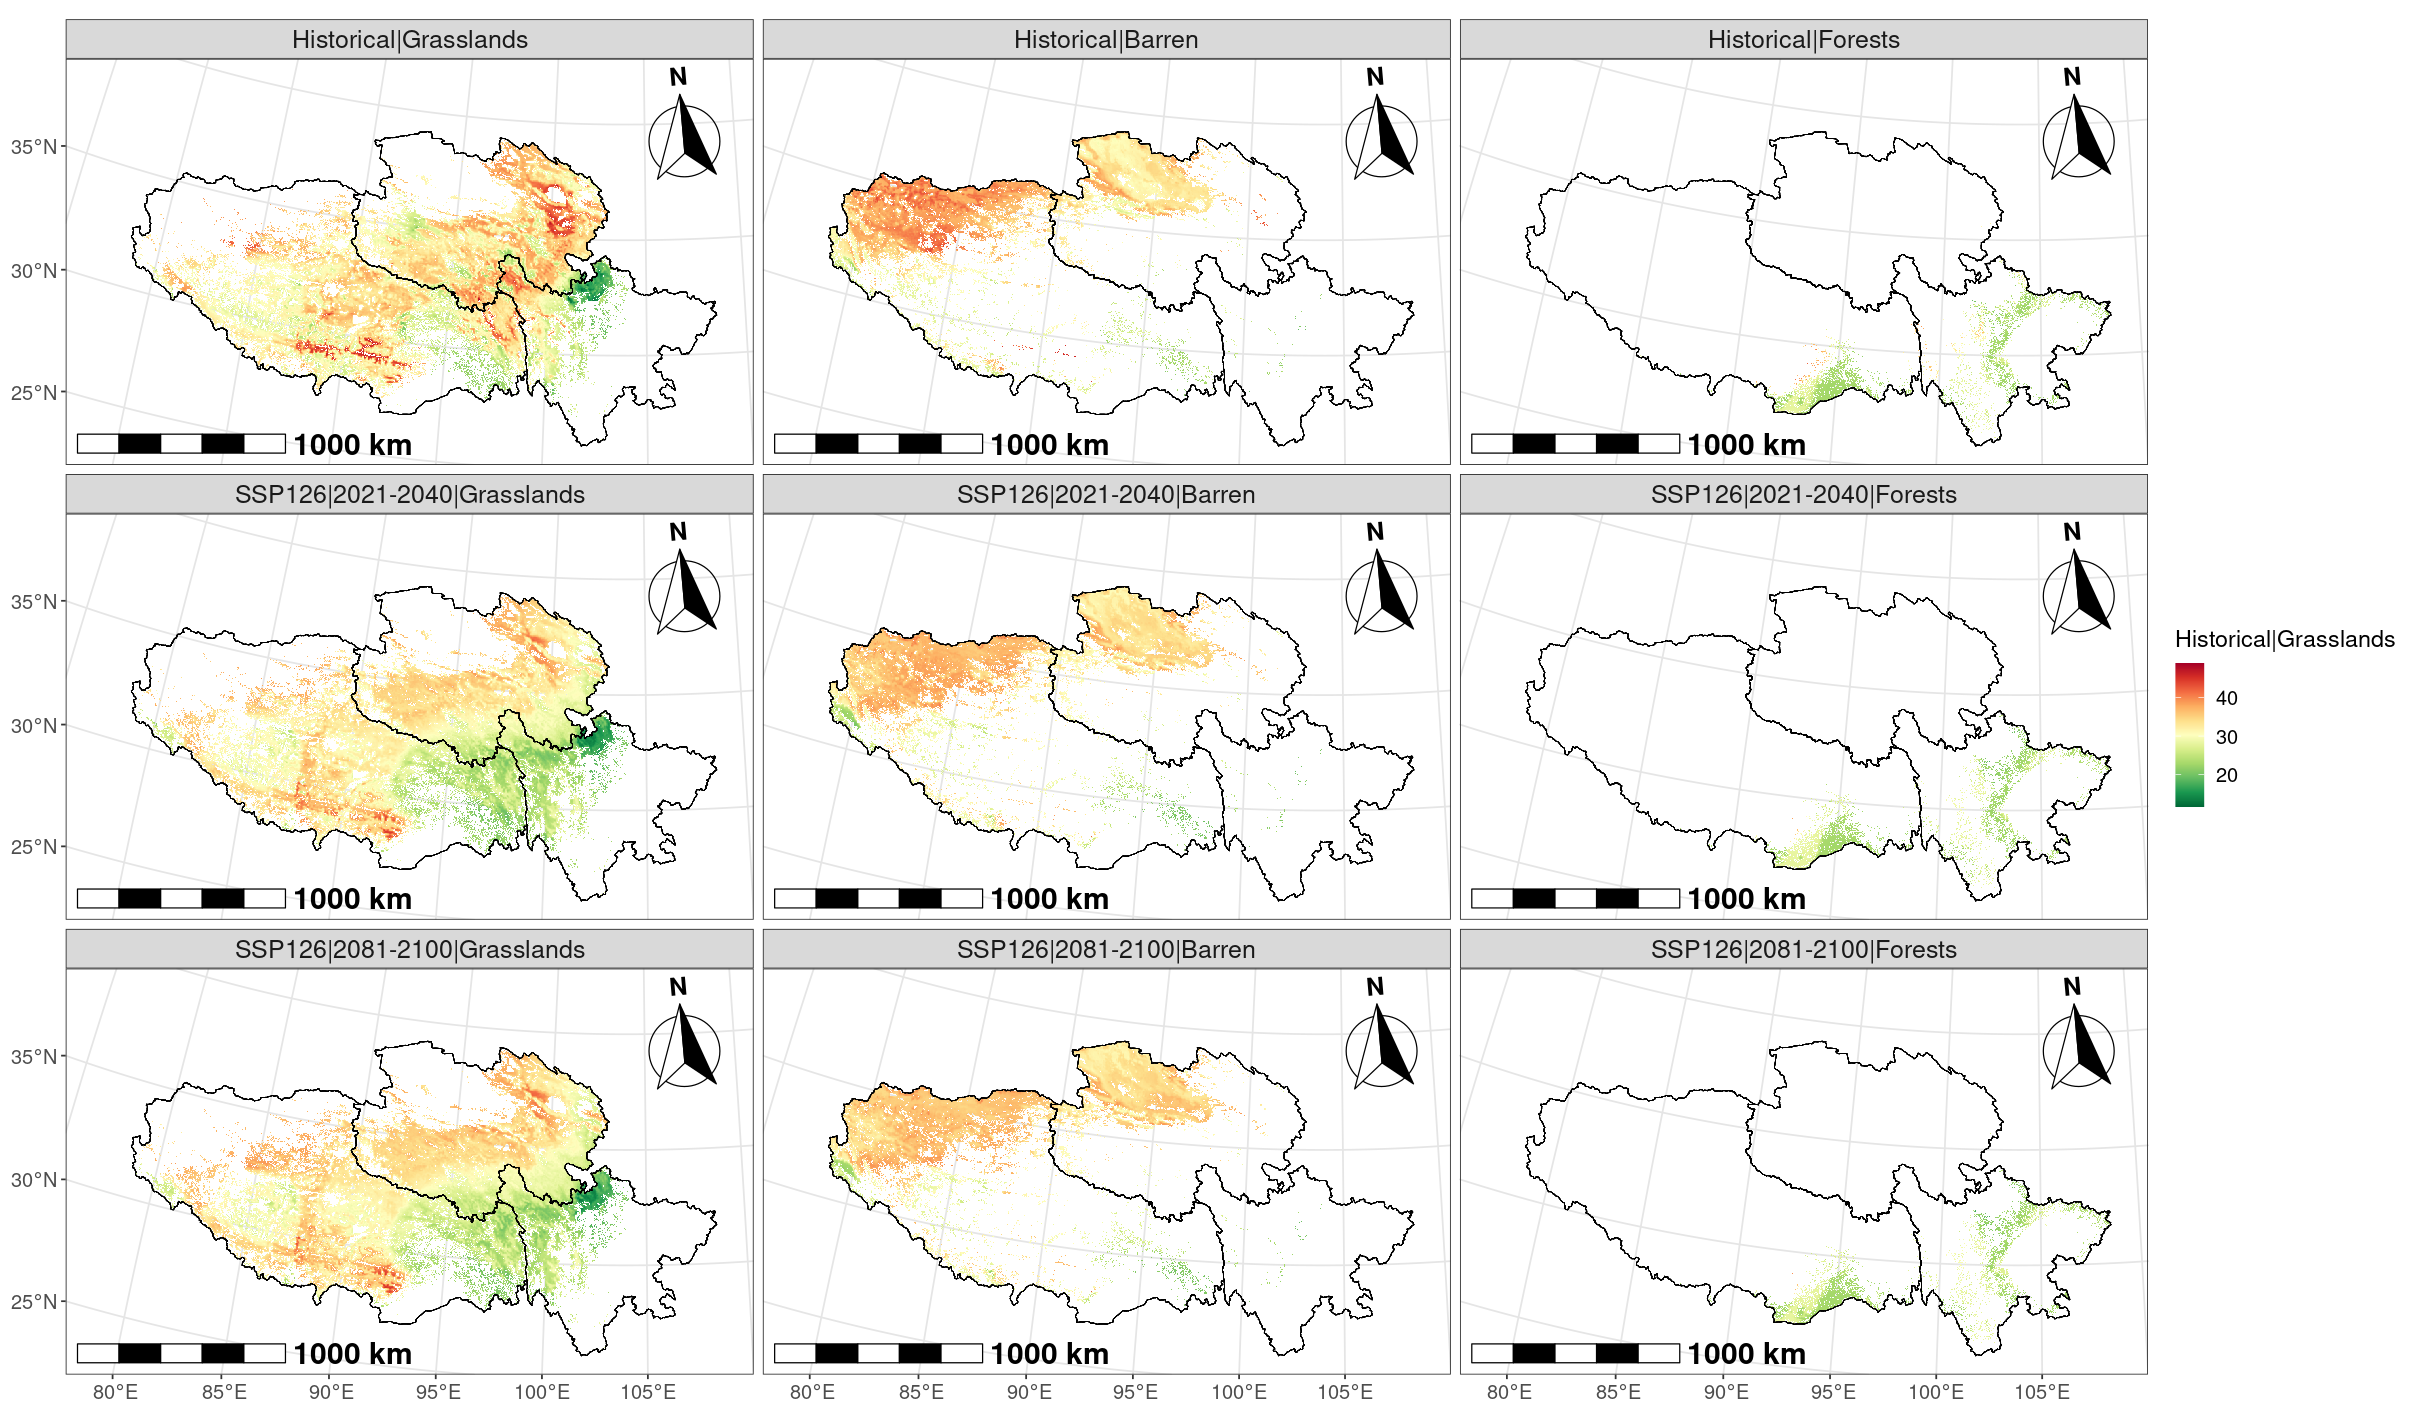

In [25]:
# Visualize the ssp126
options(repr.plot.width = 13.43*1.5, repr.plot.height = 7.9*1.5)
(p.reg.fig.ssp126 <- plot_bmap(map = dataset.dts.aliyun$map) %>% 
    add_spatraster(spat.raster = reg.visual.dat.ssp126, facet.col.nums = 3) %>% 
    add_scale_bar(size = 1.5) %>% add_north_arrow() %>%add_crs())
saved <- savePDF(object = p.reg.fig.ssp126, path = outpath, filename = "p.reg.fig.ssp126.pdf", width = 13.43*1.5, height = 7.9*1.5)

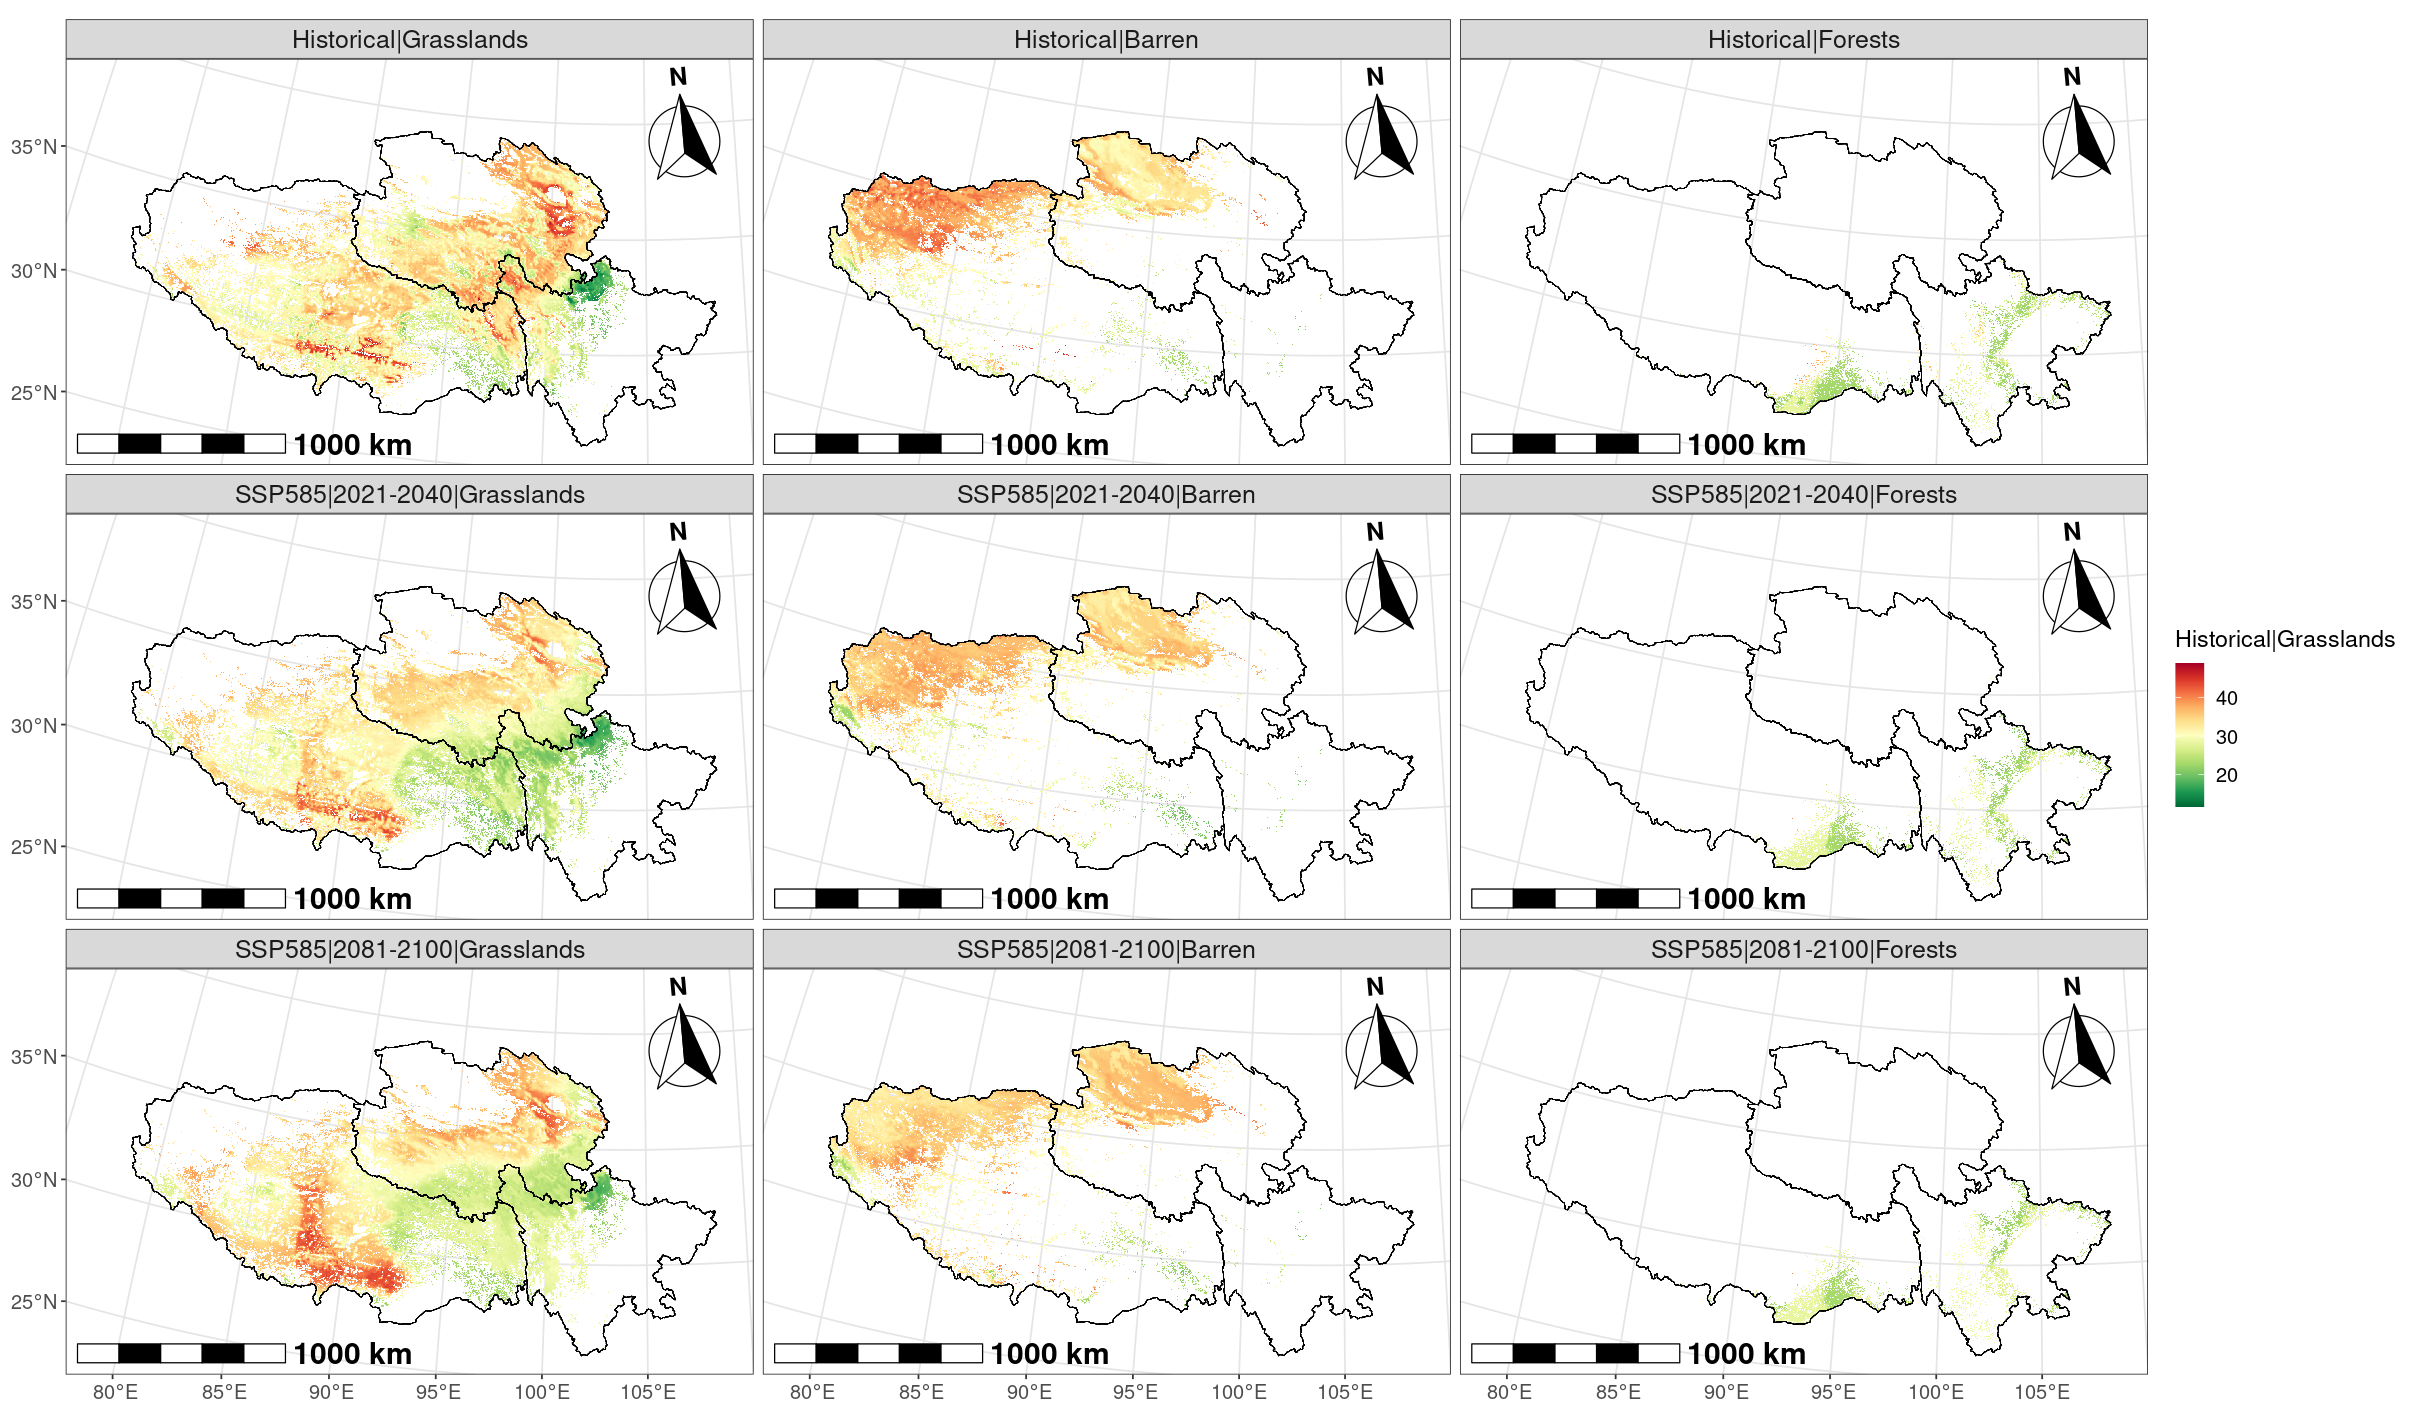

In [26]:
# Visualize the ssp585
options(repr.plot.width = 13.43*1.5, repr.plot.height = 7.9*1.5)
(p.reg.fig.ssp585 <- plot_bmap(map = dataset.dts.aliyun$map) %>% 
    add_spatraster(spat.raster = reg.visual.dat.ssp585, facet.col.nums = 3) %>% 
    add_scale_bar(size = 1.5) %>% add_north_arrow() %>%add_crs())
saved <- savePDF(object = p.reg.fig.ssp585, path = outpath, filename = "p.reg.fig.ssp585.pdf", width = 13.43*1.5, height = 7.9*1.5)

In [27]:
# Predict the probability of p__Actinobacteria predominated soil
bio <- list(10, 16, c(1:5)) # "Grasslands", "Barren", "Forests"
cla.pred.rst <- lapply(climate.data, function(climate) cla %>% predict_ml_geomap(spat.raster = climate))
cla.pred.rst.masked <- lapply(cla.pred.rst, FUN = function(pre){
    inner.res <- lapply(bio, FUN = function(b){
        mask_spatraster_by_cla(tar.spat = pre$predominated, ref.spat = dataset.dts.aliyun$spa$rast$cla$LC_Type1, use.class = b)
    })
    names(inner.res) <- c("Grasslands", "Barren", "Forests")
    inner.res
})  

In [28]:
# Prepare visualizition data: SSP126
cla.visual.dat.ssp126 <- c(
    cla.pred.rst.masked$Historical$Grasslands        , cla.pred.rst.masked$Historical$Barren        , cla.pred.rst.masked$Historical$Forests,
    cla.pred.rst.masked$`SSP126|2021-2040`$Grasslands, cla.pred.rst.masked$`SSP126|2021-2040`$Barren, cla.pred.rst.masked$`SSP126|2021-2040`$Forests,
    cla.pred.rst.masked$`SSP126|2081-2100`$Grasslands, cla.pred.rst.masked$`SSP126|2081-2100`$Barren, cla.pred.rst.masked$`SSP126|2081-2100`$Forests
)
names(cla.visual.dat.ssp126) <- c("Historical|Grasslands", "Historical|Barren", "Historical|Forests", 
                                  "SSP126|2021-2040|Grasslands", "SSP126|2021-2040|Barren", "SSP126|2021-2040|Forests",
                                  "SSP126|2081-2100|Grasslands", "SSP126|2081-2100|Barren", "SSP126|2081-2100|Forests")

In [29]:
# Prepare visualizition data: SSP585
cla.visual.dat.ssp585 <- c(
    cla.pred.rst.masked$Historical$Grasslands        , cla.pred.rst.masked$Historical$Barren        , cla.pred.rst.masked$Historical$Forests,
    cla.pred.rst.masked$`SSP585|2021-2040`$Grasslands, cla.pred.rst.masked$`SSP585|2021-2040`$Barren, cla.pred.rst.masked$`SSP585|2021-2040`$Forests,
    cla.pred.rst.masked$`SSP585|2081-2100`$Grasslands, cla.pred.rst.masked$`SSP585|2081-2100`$Barren, cla.pred.rst.masked$`SSP585|2081-2100`$Forests
)
names(cla.visual.dat.ssp585) <- c("Historical|Grasslands", "Historical|Barren", "Historical|Forests", 
                                  "SSP585|2021-2040|Grasslands", "SSP585|2021-2040|Barren", "SSP585|2021-2040|Forests",
                                  "SSP585|2081-2100|Grasslands", "SSP585|2081-2100|Barren", "SSP585|2081-2100|Forests")

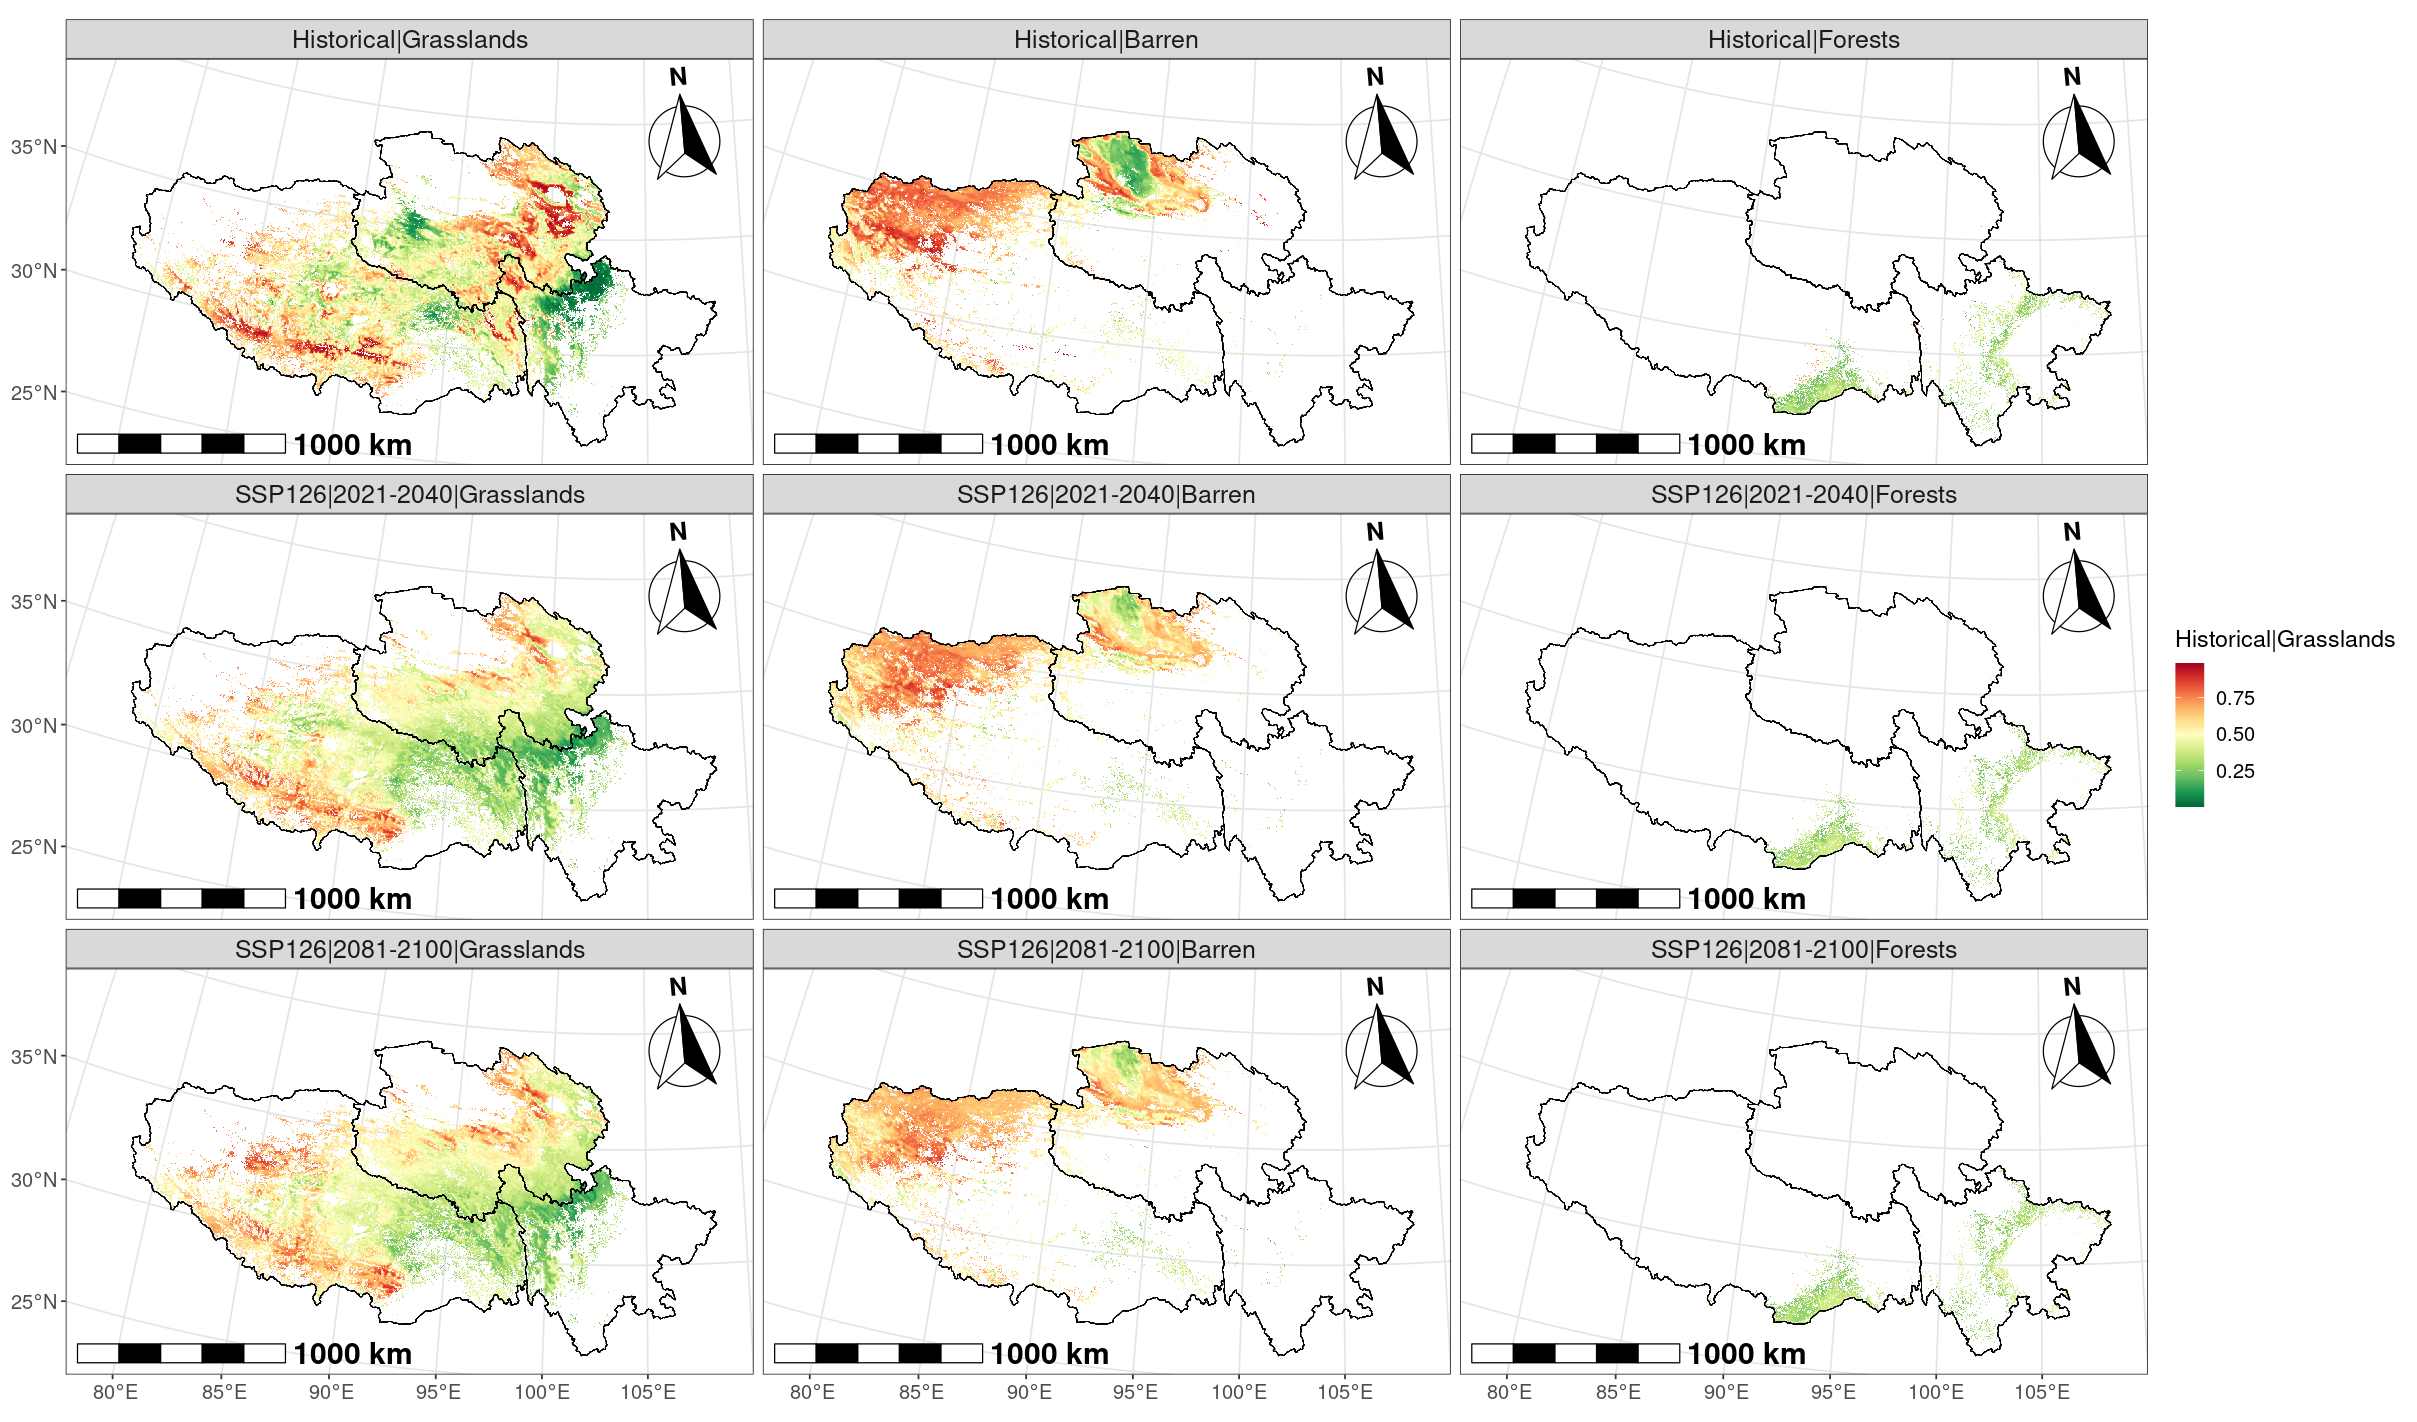

In [30]:
# Visualize the ssp126
options(repr.plot.width = 13.43*1.5, repr.plot.height = 7.9*1.5)
(p.cla.fig.ssp126 <- plot_bmap(map = dataset.dts.aliyun$map) %>% 
    add_spatraster(spat.raster = cla.visual.dat.ssp126, facet.col.nums = 3) %>% 
    add_scale_bar(size = 1.5) %>% add_north_arrow() %>%add_crs())
saved <- savePDF(object = p.cla.fig.ssp126, path = outpath, filename = "p.cla.fig.ssp126.pdf", width = 13.43*1.5, height = 7.9*1.5)

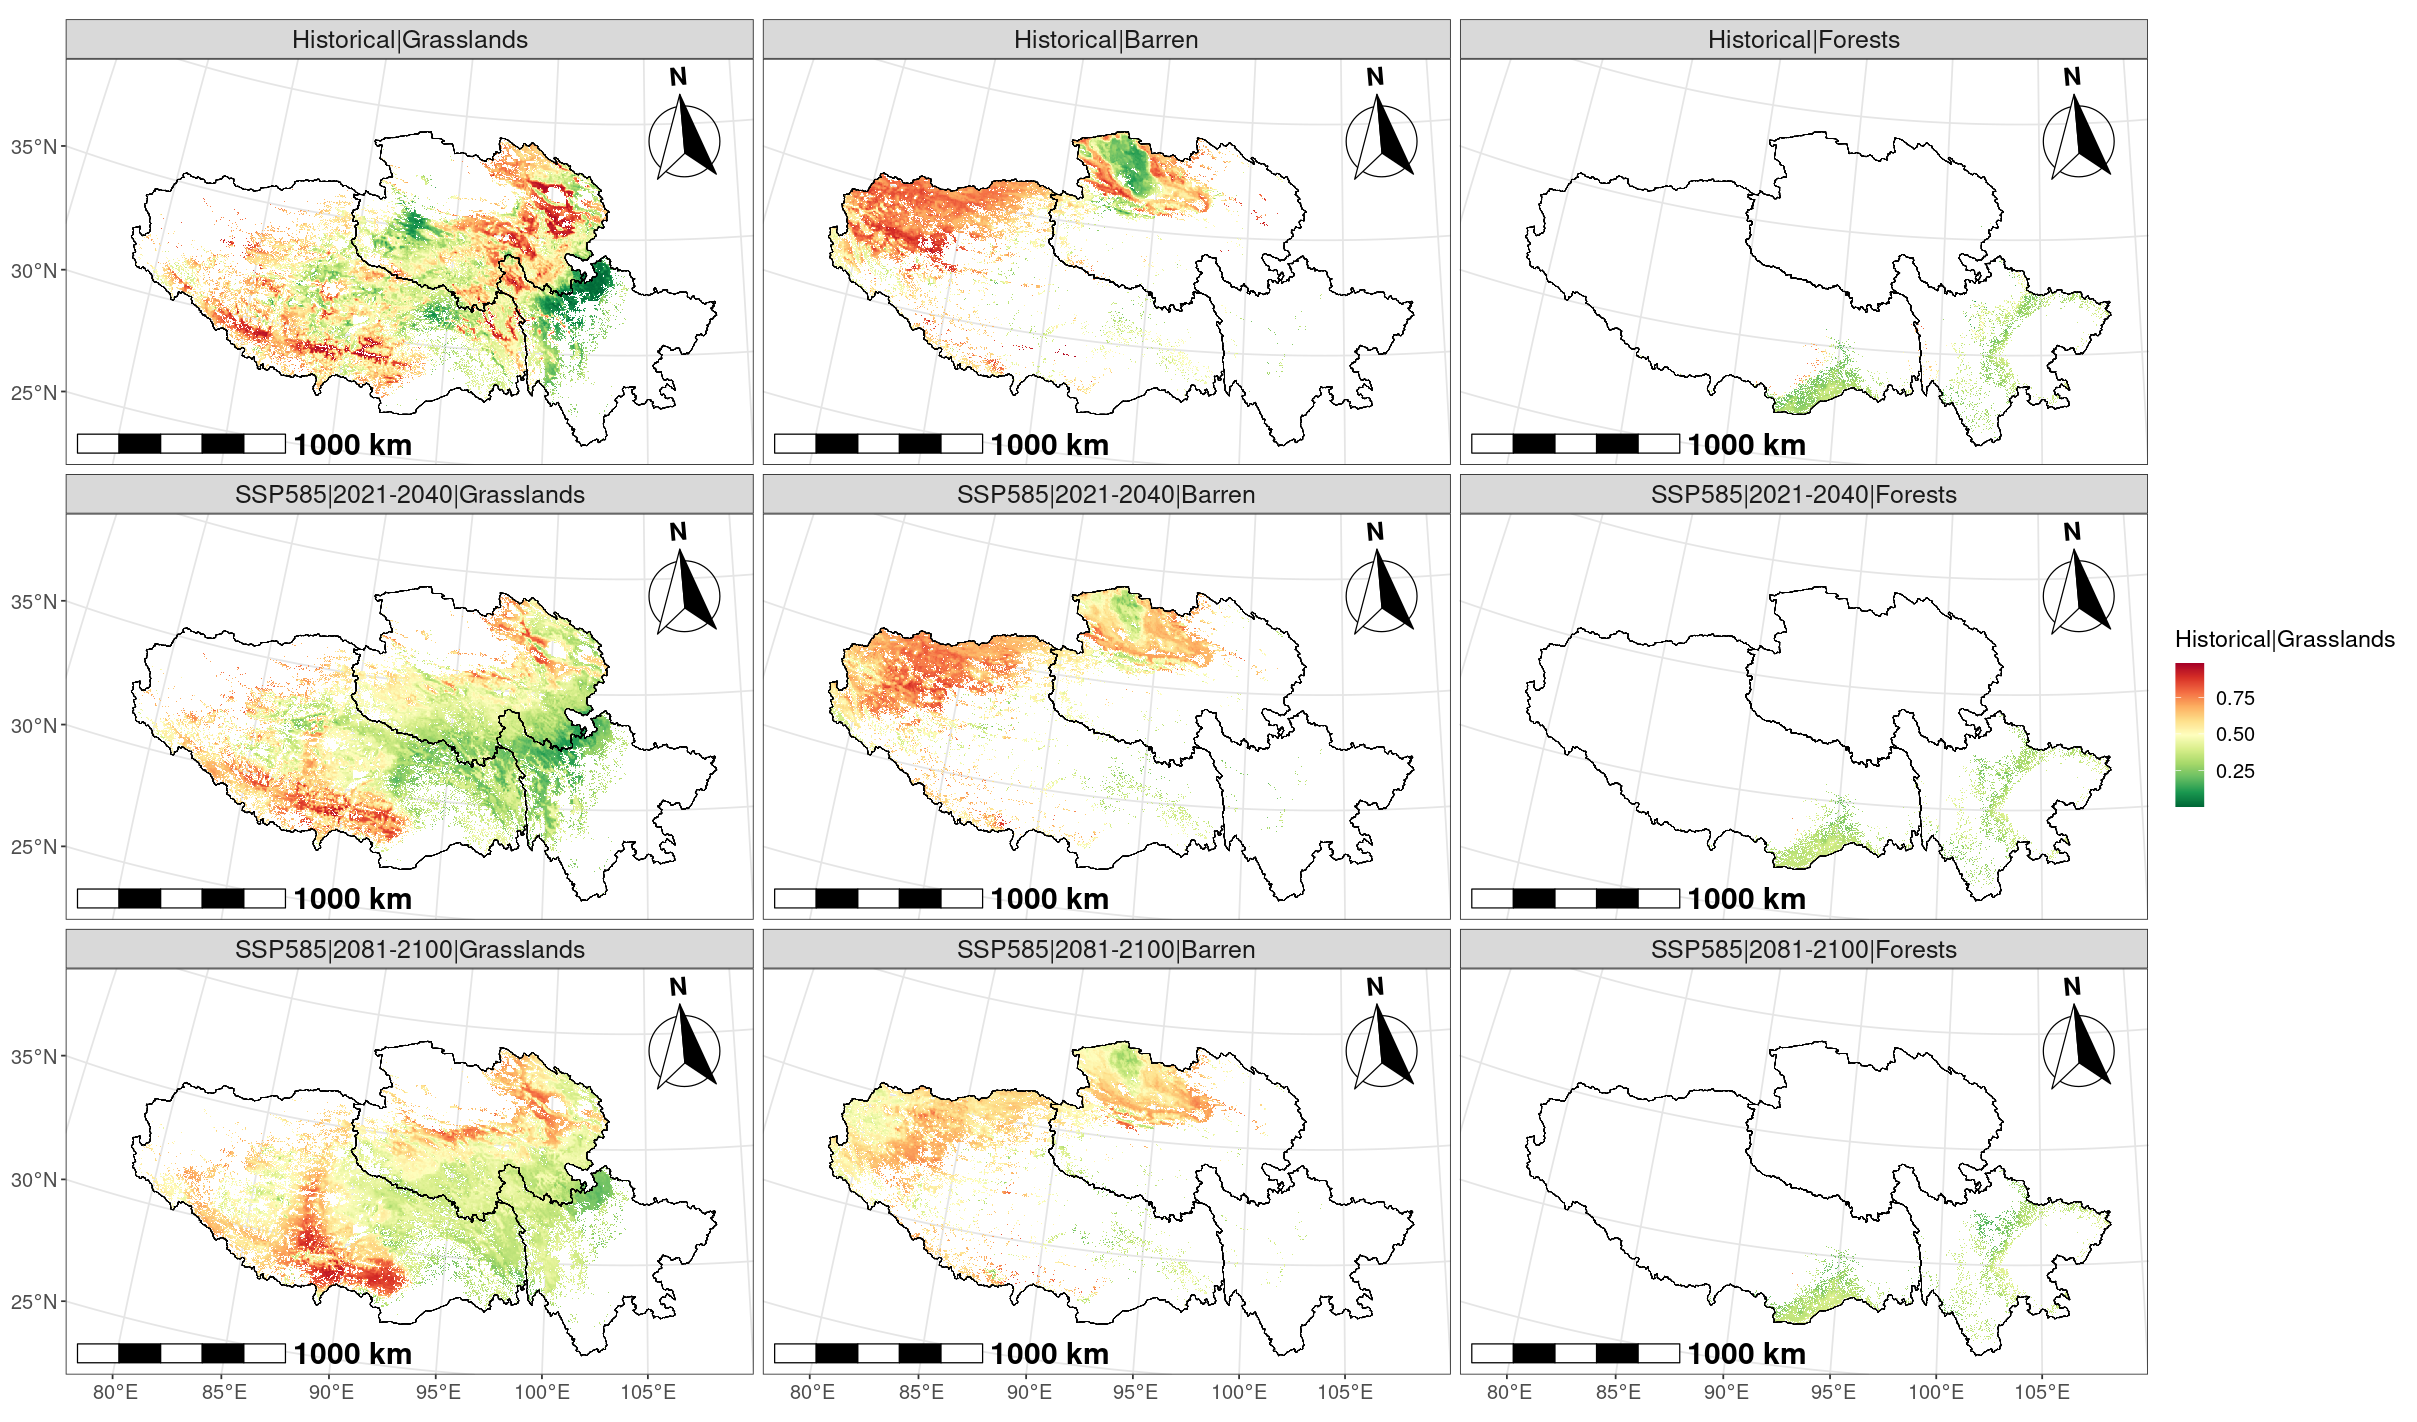

In [31]:
# Visualize the ssp585
options(repr.plot.width = 13.43*1.5, repr.plot.height = 7.9*1.5)
(p.cla.fig.ssp585 <- plot_bmap(map = dataset.dts.aliyun$map) %>% 
    add_spatraster(spat.raster = cla.visual.dat.ssp585, facet.col.nums = 3) %>% 
    add_scale_bar(size = 1.5) %>% add_north_arrow() %>%add_crs())
saved <- savePDF(object = p.cla.fig.ssp585, path = outpath, filename = "p.cla.fig.ssp585.pdf", width = 13.43*1.5, height = 7.9*1.5)